In [148]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [149]:
def f(x):
    return 3*x**2 - 4*x + 5 

In [150]:
f(3.0)

20.0

In [151]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
# plt.plot(xs, ys)

In [152]:
# more complex case
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [153]:
h = 0.0000001

# inputs
a = 2.0
b = -3.0
d = 10.0

d1 = a*b + c

b += h
d2 = a*b + c

print(f"d1 {d1}")
print(f"d2 {d2}")
print(f"derivative: {(d2 - d1)/h}")



d1 4.0
d2 4.0000002
derivative: 1.9999999967268423


In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0  # gradient
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def backward(self):
        topo = []
        visited = set()

        # simple post traversal top order
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power must be an integer or float"
        out = Value(self.data ** other, _children=(self,), _op=f"**{other}")
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        _backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
              
        return out


In [155]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

L.grad = 1.0 

L

In [158]:
"""
    L = d * f
    
    dL/dd = f
    dL/df = d

"""
f.grad = 4.0
d.grad = -2.0


"""
    dd / dc 

    d = c + e
    dd / dc = 1
    dd / de = 1

    dL/dc = dL/dd * dd/dc

"""
c.grad = -2.0
e.grad = -2.0


"""
    dL/de = -2.0
    // chain rule
    dL/da = dL/de * de/da
    
    e = a * b
    de/da = b
    de/db = a

    dL/da = -2.0 * -3.0 = 6.0
    dL/db = -2.0 * 2.0 = -4.0
"""
a.grad = 6.0
b.grad = -4.0

In [159]:
def lol():
    h = 0.0000001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2-L1)/h)

lol()

5.999999999062311


In [160]:
# inputs (x1, x2)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights (w1, w2)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias (b)
b = Value(6.881373587019543, label='b')  # tanh(2.0)

# activations -- x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'

# output (o)
o = n.tanh(); o.label = 'o'


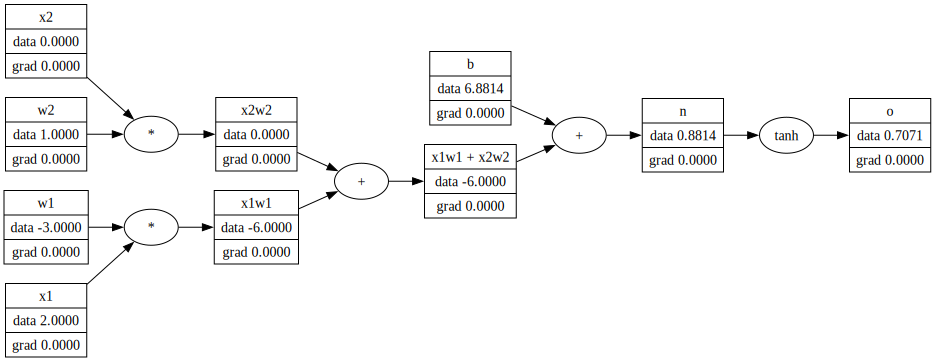

In [161]:
draw_dot(o)

In [162]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
# draw_dot(b)

In [163]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

# draw_dot(f)